# Pokemon

## Import lib & modules

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import warnings
warnings.filterwarnings("ignore")

In [16]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## Define local paths

In [3]:
csv_path = "pokemon.csv"
image_dir = "images"

df = pd.read_csv(csv_path)

df = df.dropna(subset=['Type1'])

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Type1'])
num_classes = len(label_encoder.classes_)
print(f"Classifying into {num_classes} types: {label_encoder.classes_}")

Classifying into 18 types: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']


## Custom Dataset

In [4]:
class PokemonDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name = self.df.iloc[idx]['Name']
        label = self.df.iloc[idx]['label']
        img_path = os.path.join(self.image_dir, f"{name}.png")
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        else:
            print(f"Warning: Image not found for {name} at {img_path}")
            return None, None

## Transforms, Split data, Filter out None entries

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Type1'], random_state=42)
train_dataset = PokemonDataset(train_df, image_dir, transform=transform)
test_dataset = PokemonDataset(test_df, image_dir, transform=transform)

train_dataset = [item for item in train_dataset if item[0] is not None]
test_dataset = [item for item in test_dataset if item[0] is not None]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model 

In [7]:
model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)  # Adjust the final layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs

In [8]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, LR: {scheduler.get_last_lr()[0]}")

## Evaluate

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
        print(f"Accuracy: {100 * correct / total}%")

Accuracy: 0.0%
Accuracy: 1.5625%
Accuracy: 2.0833333333333335%
Accuracy: 2.34375%
Accuracy: 3.75%
Accuracy: 3.7037037037037037%


In [10]:
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=15)
torch.save(model.state_dict(), "pokemon_type_classifier_mobilenet.pth")

Epoch 1/15, Loss: 2.6463098526000977, LR: 0.001
Epoch 2/15, Loss: 1.6919693435941423, LR: 0.001
Epoch 3/15, Loss: 0.8598053455352783, LR: 0.001
Epoch 4/15, Loss: 0.504639880997794, LR: 0.001
Epoch 5/15, Loss: 0.460908731179578, LR: 0.0001
Epoch 6/15, Loss: 0.21439054643823988, LR: 0.0001
Epoch 7/15, Loss: 0.08599689177104405, LR: 0.0001
Epoch 8/15, Loss: 0.04012395375009094, LR: 0.0001
Epoch 9/15, Loss: 0.019662283937491122, LR: 0.0001
Epoch 10/15, Loss: 0.017293140269993318, LR: 1e-05
Epoch 11/15, Loss: 0.04499233682595548, LR: 1e-05
Epoch 12/15, Loss: 0.024730840077002842, LR: 1e-05
Epoch 13/15, Loss: 0.05662496006559758, LR: 1e-05
Epoch 14/15, Loss: 0.016607984767428467, LR: 1e-05
Epoch 15/15, Loss: 0.014657593199184962, LR: 1.0000000000000002e-06


In [11]:
def predict_type(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return label_encoder.inverse_transform([predicted.item()])[0]

# Usage example
test_image = "charmander.png"
print(f"Predicted Type: {predict_type(test_image)}")

Image not found: charmander.png
Predicted Type: None


In [12]:
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, labels=range(num_classes), target_names=label_encoder.classes_, zero_division=0))

              precision    recall  f1-score   support

         Bug       0.45      0.36      0.40        14
        Dark       0.17      0.17      0.17         6
      Dragon       0.25      0.40      0.31         5
    Electric       0.11      0.12      0.12         8
       Fairy       0.25      0.25      0.25         4
    Fighting       0.33      0.17      0.22         6
        Fire       0.45      0.45      0.45        11
      Flying       0.00      0.00      0.00         0
       Ghost       0.00      0.00      0.00         5
       Grass       0.56      0.56      0.56        16
      Ground       0.12      0.17      0.14         6
         Ice       0.00      0.00      0.00         5
      Normal       0.21      0.29      0.24        21
      Poison       0.14      0.14      0.14         7
     Psychic       0.08      0.09      0.08        11
        Rock       0.20      0.11      0.14         9
       Steel       0.33      0.20      0.25         5
       Water       0.42    

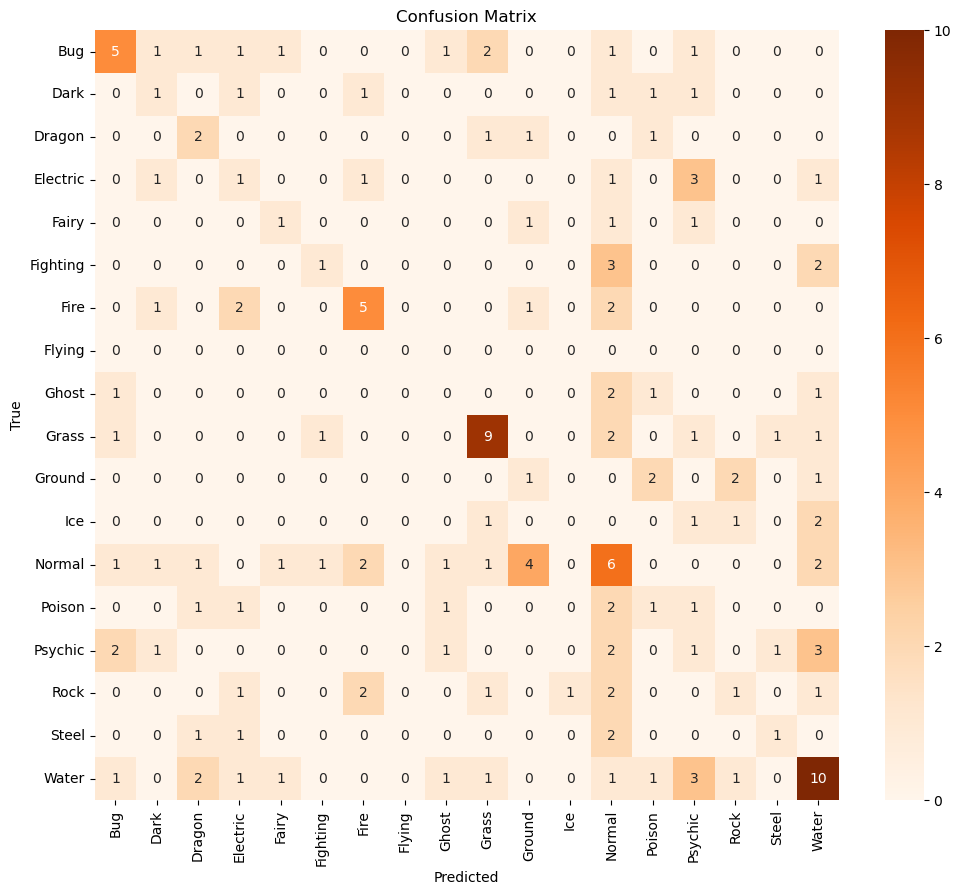

In [13]:
# Confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

Epoch 1/10 | Loss: 0.0274 | Accuracy: 0.9985
Epoch 2/10 | Loss: 0.0393 | Accuracy: 0.9969
Epoch 3/10 | Loss: 0.0171 | Accuracy: 1.0000
Epoch 4/10 | Loss: 0.0132 | Accuracy: 1.0000
Epoch 5/10 | Loss: 0.0156 | Accuracy: 1.0000
Epoch 6/10 | Loss: 0.0231 | Accuracy: 0.9985
Epoch 7/10 | Loss: 0.0142 | Accuracy: 1.0000
Epoch 8/10 | Loss: 0.0225 | Accuracy: 0.9969
Epoch 9/10 | Loss: 0.0173 | Accuracy: 1.0000
Epoch 10/10 | Loss: 0.0165 | Accuracy: 1.0000


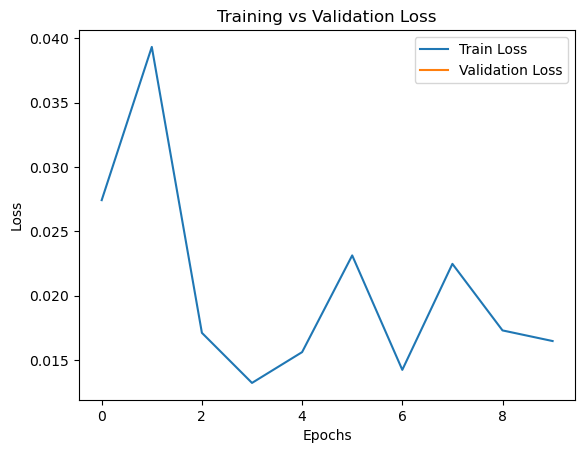

In [17]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

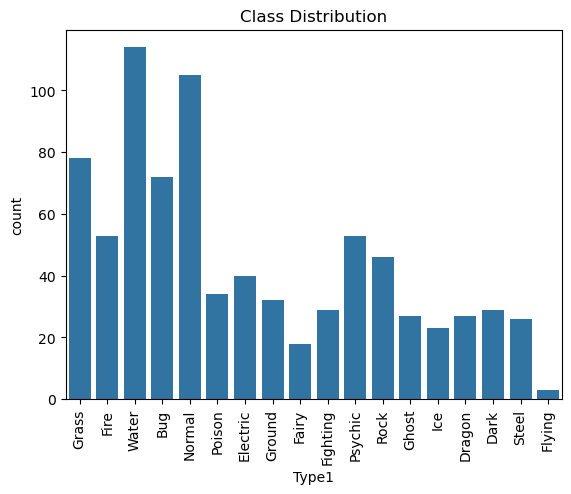

In [18]:
sns.countplot(x=df["Type1"])
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.show()

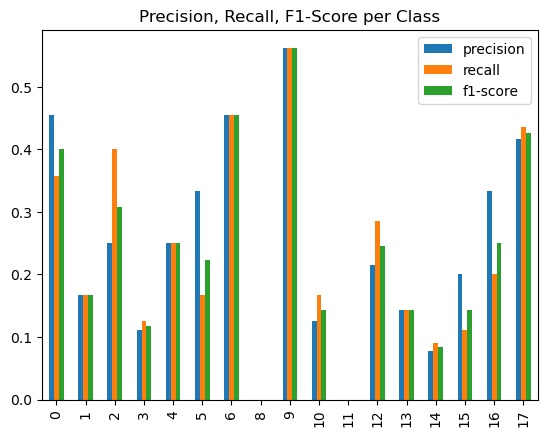

In [19]:
report = classification_report(all_labels, all_preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:-3, :3].plot(kind="bar")
plt.title("Precision, Recall, F1-Score per Class")
plt.xticks(rotation=90)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


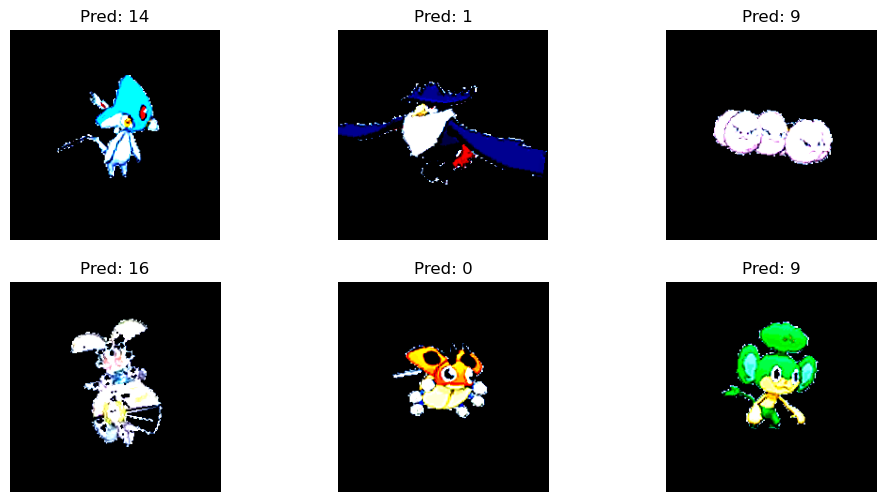

In [20]:
model.eval()
images, labels = next(iter(train_loader))
images = images.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12,6))

for i in range(6):
    plt.subplot(2,3,i+1)
    img = images[i].cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(f"Pred: {preds[i].item()}")
    plt.axis("off")

plt.show()

In [21]:
fire_df = df[df["Type1"] == "Fire"]
print(fire_df.head())
print("Total Fire Pokémon:", len(fire_df))

          Name Type1   Type2   Evolution  label
3   charmander  Fire     NaN  charmeleon      6
4   charmeleon  Fire     NaN   charizard      6
5    charizard  Fire  Flying         NaN      6
36      vulpix  Fire     NaN   ninetales      6
37   ninetales  Fire     NaN         NaN      6
Total Fire Pokémon: 53


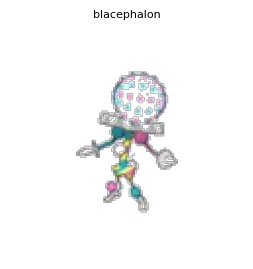

In [22]:
fire_df = df[df["Type1"] == "Fire"]
num_images = len(fire_df)   # should be 53
cols = 8                    # number of columns (you can change)
rows = math.ceil(num_images / cols)

plt.figure(figsize=(20, rows * 3))

for i, (_, row) in enumerate(fire_df.iterrows()):
    img_path = os.path.join("images", row["Name"] + ".png")  # change extension if needed
    
    if not os.path.exists(img_path):
        continue
img = Image.open(img_path)

plt.subplot(rows, cols, i+1)
plt.imshow(img)
plt.title(row["Name"], fontsize=8)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
dark_df = df[df["Type1"] == "Dark"]
print(dark_df.head())
print("Total Dark Pokémon:", len(dark_df))

In [ ]:
dark_df_df = df[df["Type1"] == "Dark"]
num_images = len(dark_df)  
cols = 8                   
rows = math.ceil(num_images / cols)

plt.figure(figsize=(20, rows * 3))

for i, (_, row) in enumerate(dark_df.iterrows()):
    img_path = os.path.join("images", row["Name"] + ".png") 
    
    if not os.path.exists(img_path):
        continue
    
img = Image.open(img_path)
plt.subplot(rows, cols, i+1)
plt.imshow(img)
plt.title(row["Name"], fontsize=8)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
combo_df = df[
    ((df["Type1"] == "Fire") & (df["Type2"] == "Flying")) |
    ((df["Type1"] == "Flying") & (df["Type2"] == "Fire"))
]

print("Total Fire + Flying Pokémon:", len(combo_df))
combo_df.head()

In [ ]:
num_images = len(combo_df)

cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(15, rows * 3))

for i, (_, row) in enumerate(combo_df.iterrows()):
    img_path = os.path.join("images", row["Name"] + ".png")  # change extension if needed
    
    if not os.path.exists(img_path):
        continue

img = Image.open(img_path)

plt.subplot(rows, cols, i+1)
plt.imshow(img)
plt.title(row["Name"], fontsize=9)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:

df["Type2"] = df["Type2"].fillna("None")
df["TypeCombo"] = df.apply(lambda x: " + ".join(sorted([x["Type1"], x["Type2"]])),axis=1)
all_combos = df["TypeCombo"].unique()

print("Total Unique Combinations:", len(all_combos))
print(all_combos)

In [ ]:
combo_counts = df["TypeCombo"].value_counts()
combo_counts.plot(kind="bar", figsize=(15,6))
plt.xticks(rotation=90)
plt.title("All Pokémon Type Combinations")
plt.ylabel("Count")
plt.show()